In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = [15, 12]
sns.set_palette('Dark2_r', 7)

pd.set_option('display.max_columns', 50)

ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')
movies = pd.read_csv('data/movies.csv')

In [2]:
rating_count = ratings[['movieId', 'rating']].groupby('movieId').count()
rating_count = rating_count.rename(columns={'rating':'review_count'})

# find rating per movie
rating_overall = ratings[['movieId', 'rating']].groupby('movieId').mean()
rating_overall = rating_overall.rename(columns={'rating':'average_review'})

movies = movies.join(rating_overall, on='movieId').join(rating_count, on='movieId')

In [3]:
movies['year'] = movies['title'].str.extract(r'.*\(([0-9]*)\)')

# only 13 titles don't conform to this format, pretty good
movies = movies.query('not year.isnull()')
movies['year'] = movies['year'].astype(int)
movies.tail()

,movieId,title,genres,average_review,review_count,year
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.0,1.0,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.5,1.0,2017
9739,193585,Flint (2017),Drama,3.5,1.0,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.5,1.0,2018
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,4.0,1.0,1991


It's awesome that we have the movie year to work with, but it's hard to make good visualizations with this many years to span.  Let's try binning into decades.

The majority of movies in this dataset were made after 1950, but we have a couple stragglers ranging back all the way to 1902.  To give ourselves fewer classes to visualize, let's use 1950 as a somewhat arbitrary cutoff.

In [4]:
movies = movies.query('year >= 1950')

decades = {d: str(d) + 's' for d in range(1950, 2020, 10)}
decades

movies['decade'] = movies['year'].apply(lambda y: decades[y - (y%10)])

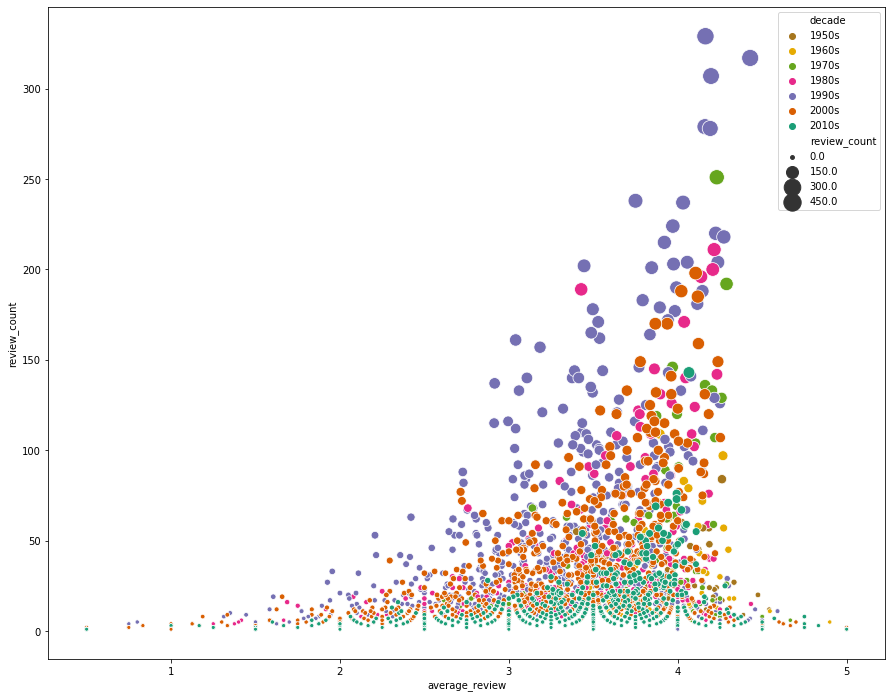

In [5]:
sns.scatterplot(x='average_review', y='review_count', hue='decade', size='review_count', data=movies,
                hue_order=list(decades.values()),
                sizes=(15, 300))

Cool!  It seems as though a movie having been around for a couple decades allows it to get more reviews.  But not too old, the 90's seem to be ideal for most reviews, followed by the 80's and 2000's.  We can also see a glut of 60's movies with pretty high reviews with 50-100 ratings -- I wonder if older movies are scored more charitably?

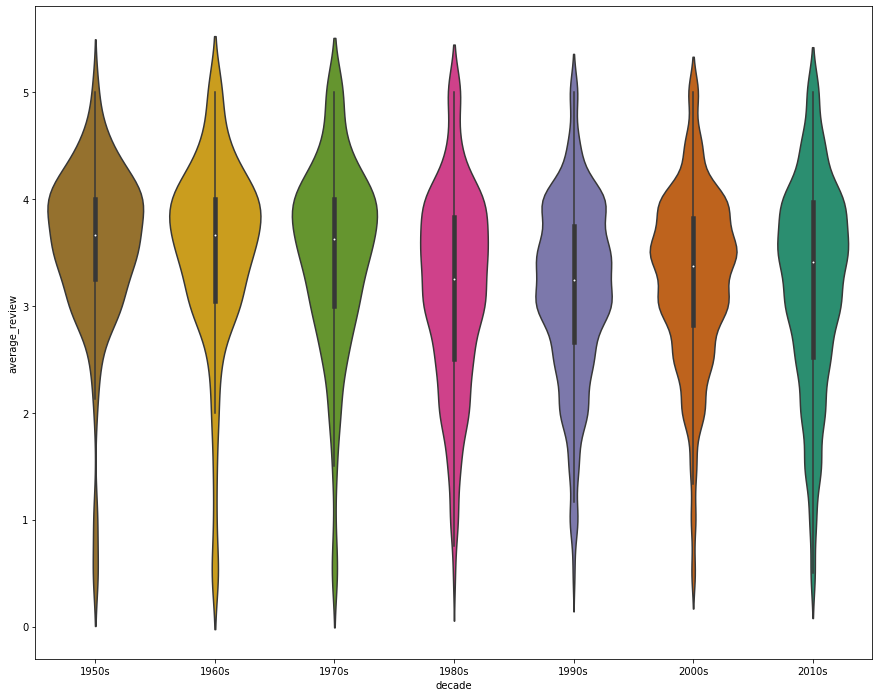

In [6]:
sns.violinplot(x='decade', y='average_review', data=movies,
               order=list(decades.values()),
               hue_order=list(decades.values())
               )

From this graph we can see that yes, older movies do get higher ratings!  Specifically, those from the 50's through 70's tend to recieve more favorable reviews, maybe due to rose tinted glasses?  Another reasonable explanation is that with old movies, only the best are actually remembered and reviewed on websites that launched decades after their original openings.

Also, it looks like the 80's contains more controversial films than of the decade before and after.

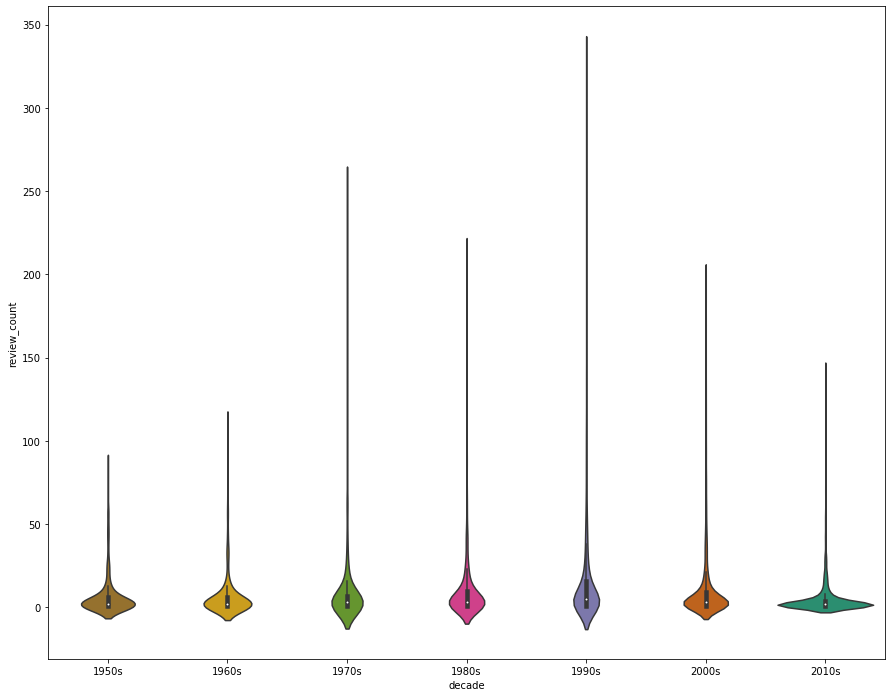

In [7]:
sns.violinplot(x='decade', y='review_count', data=movies,
               order=list(decades.values()),
               hue_order=list(decades.values()),
               )

It turns out that the vast majority of movies from all decades have almost no reviews, and a couple enter multi-hundereds.  This plot was a bit of a miss.

Now let's take a look at movies by category.  Keep in mind when looking at this data that many movies are part of multiple categories will appear in the results of each category, and that movies with no category will not appear at all.

In [8]:
categories = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
              'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']

cat_list = []
for c in categories:
    m = movies[movies.genres.str.contains(c)]
    m['genre'] = c
    cat_list.append(m)
    
cat_movies = pd.concat(cat_list, axis=0)

/home/alex/EECS_731/p7/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


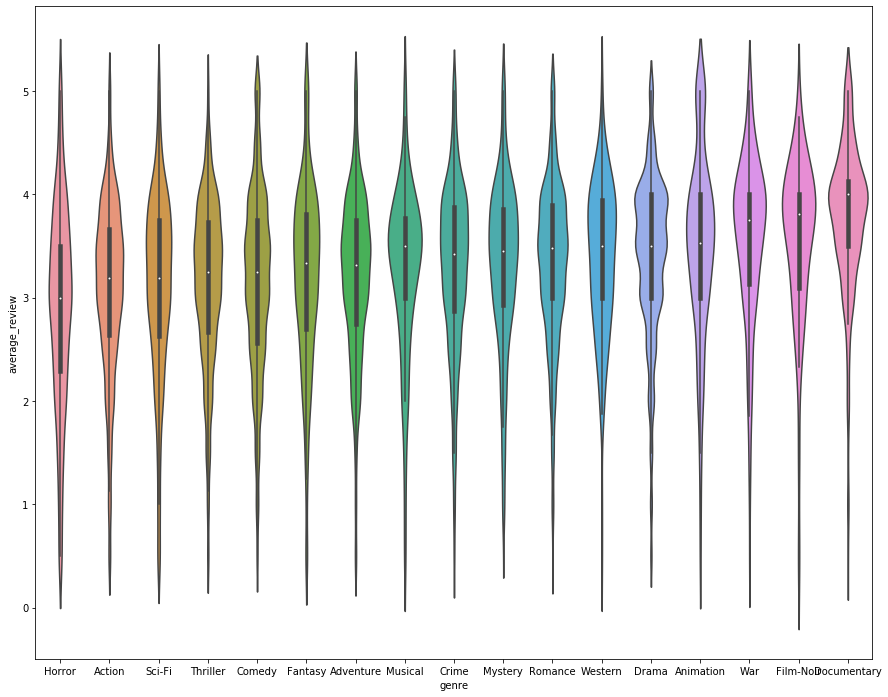

In [9]:
cat_sorted = cat_movies.groupby('genre').mean().reset_index().sort_values(by='average_review')['genre']

sns.violinplot(x='genre', y='average_review', data=cat_movies, order=cat_sorted)

After sorting by average review score, this visualization and its conclusions becomes very apparent.  Documentaries are highest rated (and with much lower deviation from the mean than other categories), and horror is unsurprisingly generally the worst rated (with a very high spread too).

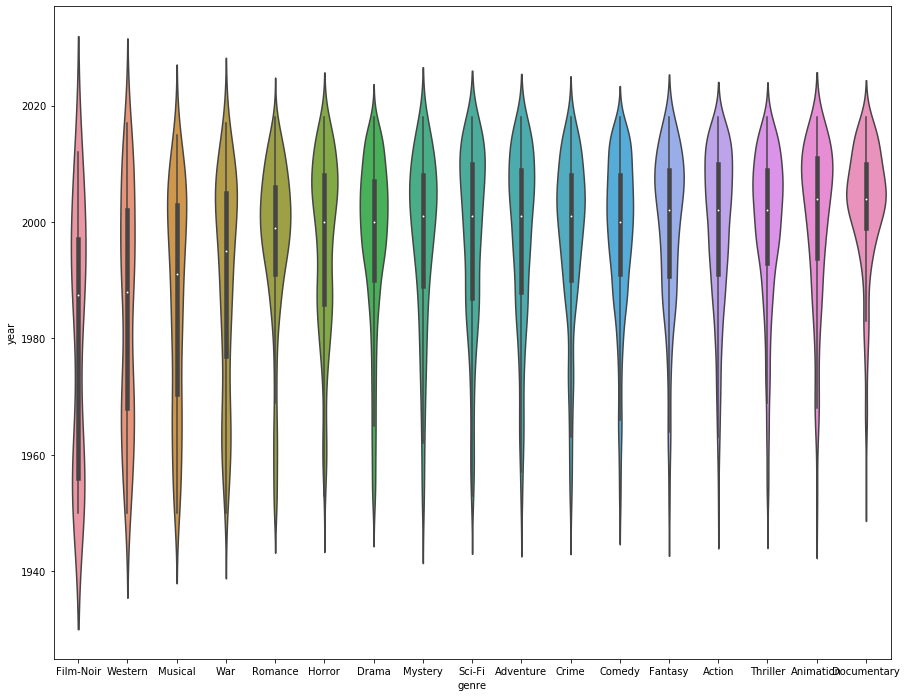

In [10]:
cat_sorted = cat_movies.groupby('genre').mean().reset_index().sort_values(by='year')['genre']

sns.violinplot(x='genre', y='year', data=cat_movies, order=cat_sorted)

This plot was more insightful than I expected!  It's really interesting to see Film-Noir take on a bimodal distribution, with a lull in the 70's.  Documentaries and animated films appear to be predominantly recent fields by comparison.

Up until now we've had some good quantitative data, but what about qualitative?  For this, we might look at the tag data.  Let's see what happens when we produce word clouds by each genre.

In [13]:
tag_movies = cat_movies.merge(tags, on='movieId', how='inner')

/home/alex/EECS_731/p7/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


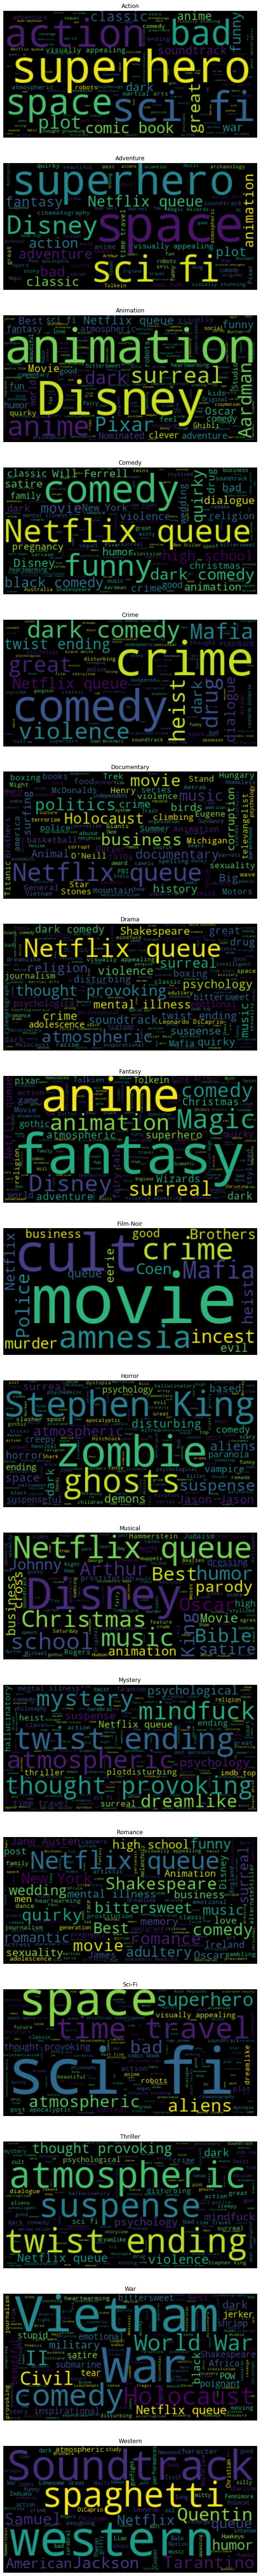

In [15]:
try:
    categories.remove("Children's")
except:
    pass

fig, axs = plt.subplots(len(categories))

for ax, c in zip(axs, categories):
    text = ''
    for t in tag_movies.query(f"genre == \"{c}\"")['tag']:
        text += ' ' + t
        
    if len(text) == 0:
        continue

    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    
    ax.title.set_text(c)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

fig.set_size_inches(12, 100)
fig.show()

Nice!  Moving down the list, it's clear that superheroes are a big deal in the genres of Action and Adventure.  Mafias, heists, and drugs are common subjects of Crime movies (go figure).  Documentaries are about politics, the Holocaust, business, and Star Trek.  We can see that Stephen King has had a huge impact on Horror, and that Disney is a household name in many genres.  Interestingly, the Vietnam war appears to be more prominent than World War II in War movies.

It's curious to see 'Netflix queue' appear in many of these word clouds.  My theory is that this as a tag is a command for Netflix to queue the movie.

# Conclusion

We were able to discern a lot from clever visuals!  First, the movies with highest quantity of reviews are from the 90's, not before or after.  Reviewers appear to have rose-colored glasses though, as the highest decades are the 50's, 60's, and 70's.  Next, Documentaries get consistently good ratings, whereas Horror films see a much higher spread in average reviews, and generally worse as well.  Finally, we learned that Disney is a prominent actor in many genres, from Musical to Fantasy to Animation, and that people are using MovieLens tags to add movies to their netflix queues.